In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn

from pit.dynamics.kinematic_bicycle_f110 import KinematicBicycle_Steer
from pit.integration import Euler, RK4
from pit.data_processor.csv_loader import fetch_aligned_trajectory_data

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [2]:
"""
ACCELERATION

class pid:


if current_speed > 0.:
    if (vel_diff > 0):
        # accelerate
        kp = 10.0 * max_a / max_v
        accl = kp * vel_diff
    else:
        # braking
        kp = 10.0 * max_a / (-min_v)
        accl = kp * vel_diff
"""

class VelocityPID(nn.Module):
    # Assume always go one direction(current_speed>0)
    def __init__(self, max_accel, min_accel, switch_v, dt) -> None:
        super().__init__()
        self.max_accel = torch.nn.Parameter(torch.tensor(max_accel, dtype=torch.float32), requires_grad=False)
        self.min_accel = torch.nn.Parameter(torch.tensor(min_accel, dtype=torch.float32), requires_grad=False)
        self.switch_v = torch.nn.Parameter(torch.tensor(switch_v, dtype=torch.float32), requires_grad=False)
        self.dt = torch.nn.Parameter(torch.tensor(dt, dtype=torch.float32), requires_grad=False)

    def forward(self, current_speed, desired_speed):
        vel_diff = desired_speed - current_speed
        accel = vel_diff / self.dt
        accel = torch.min(torch.max(accel, self.min_accel), self.max_accel)
        #
        # if current_speed > self.switch_v:
        #     accel = accel * (self.switch_v / current_speed)
        return accel

class PacejkaTireModel(nn.Module):
    def __init__(self, initial_value, params_index, vel_pid) -> None:
        """
        params_index = {
            "X": 0,
            "Y": 1,
            "DELTA": 2,
            "YAW": 3,
            "VX": 4,
            "VY": 5,
            "YAWRATE": 6,

            "STEER": 0,
            "VEL": 1

            "FYF": 0,
            "FYR": 1,
        }
        """
        super().__init__()
        self.lf = torch.nn.Parameter(torch.tensor(initial_value['lf'], dtype=torch.float32), requires_grad=False)
        self.lr = torch.nn.Parameter(torch.tensor(initial_value['lr'], dtype=torch.float32), requires_grad=False)
        self.Iz = torch.nn.Parameter(torch.tensor(initial_value['Iz'], dtype=torch.float32), requires_grad=False)
        self.mass = torch.nn.Parameter(torch.tensor(initial_value['mass'], dtype=torch.float32), requires_grad=False)
        self.Df = torch.nn.Parameter(torch.tensor(initial_value['Df'], dtype=torch.float32), requires_grad=False)
        self.Cf = torch.nn.Parameter(torch.tensor(initial_value['Cf'], dtype=torch.float32), requires_grad=False)
        self.Bf = torch.nn.Parameter(torch.tensor(initial_value['Bf'], dtype=torch.float32), requires_grad=False)
        self.Ef = torch.nn.Parameter(torch.tensor(initial_value['Ef'], dtype=torch.float32), requires_grad=False)
        self.Dr = torch.nn.Parameter(torch.tensor(initial_value['Dr'], dtype=torch.float32), requires_grad=False)
        self.Cr = torch.nn.Parameter(torch.tensor(initial_value['Cr'], dtype=torch.float32), requires_grad=False)
        self.Br = torch.nn.Parameter(torch.tensor(initial_value['Br'], dtype=torch.float32), requires_grad=False)
        self.Er = torch.nn.Parameter(torch.tensor(initial_value['Er'], dtype=torch.float32), requires_grad=False)
        self.mu = torch.nn.Parameter(torch.tensor(initial_value['mu'], dtype=torch.float32), requires_grad=False)
        self.h = torch.nn.Parameter(torch.tensor(initial_value['h'], dtype=torch.float32), requires_grad=False)

        self.g = 9.81
        self.vel_pid = vel_pid

        for key, value in params_index.items():
            setattr(self, key, value)

    def forward(self, states, control_inputs):
        """ Get the tire forces at this point

        Args:
            states (): Shape of (B, 7) or (7)
            control_inputs (): Shape of (B, 2) or (2)
        Returns:
            tire_forces (): Shape of (B, 3) or (3) [Frx, Ffy, Fry]
        """
        batch_mode = True if len(states.shape)==2 else False
        device = self.mass.device
        if batch_mode:
            B = states.shape[0]
            accel = self.vel_pid(states[:, self.VX], control_inputs[:, self.VEL])
            tire_forces = torch.zeros((B, 2), device=device)
            alpha_f = -torch.arctan((states[:, self.VY] + states[:, self.YAWRATE]*self.lf)/states[:, self.VX]) + states[:, self.DELTA]
            alpha_r = -torch.arctan((states[:, self.VY] - states[:, self.YAWRATE]*self.lr)/states[:, self.VX])
            F_zf = self.mass * (-self.h * accel + self.lr * self.g) / (self.lr + self.lf)
            F_zr = self.mass * (self.h * accel + self.lf * self.g) / (self.lr + self.lf)
            # F_yf = mu * F_zf * D_f * math.sin(C_f * math.atan(B_f * alpha_f - E_f * (B_f * alpha_f - math.atan(B_f * alpha_f))))
            tire_forces[:, self.FFY] = self.mu * F_zf * self.Df * torch.sin(self.Cf * torch.arctan(self.Bf * alpha_f - self.Ef*(self.Bf * alpha_f - torch.arctan(self.Bf * alpha_f))))
            tire_forces[:, self.FRY] = self.mu * F_zr * self.Dr * torch.sin(self.Cr * torch.arctan(self.Br * alpha_r - self.Er*(self.Br * alpha_r - torch.arctan(self.Br * alpha_r))))
        else:
            accel = self.vel_pid(states[self.VX], control_inputs[self.VEL])
            tire_forces = torch.zeros((2), device=device)
            alpha_f = -torch.arctan((states[self.VY] + states[self.YAWRATE]*self.lf)/states[self.VX]) + states[self.DELTA]
            alpha_r = -torch.arctan((states[self.VY] - states[self.YAWRATE]*self.lr)/states[self.VX])
            F_zf = self.mass * (-self.h * accel + self.lr * self.g) / (self.lr + self.lf)
            F_zr = self.mass * (self.h * accel + self.lf * self.g) / (self.lr + self.lf)
            # F_yf = mu * F_zf * D_f * math.sin(C_f * math.atan(B_f * alpha_f - E_f * (B_f * alpha_f - math.atan(B_f * alpha_f))))
            tire_forces[self.FFY] = self.mu * F_zf * self.Df * torch.sin(self.Cf * torch.arctan(self.Bf * alpha_f - self.Ef*(self.Bf * alpha_f - torch.arctan(self.Bf * alpha_f))))
            tire_forces[self.FRY] = self.mu * F_zr * self.Dr * torch.sin(self.Cr * torch.arctan(self.Br * alpha_r - self.Er*(self.Br * alpha_r - torch.arctan(self.Br * alpha_r))))
        return tire_forces


class DynamicBicycle_Steer(nn.Module):
    """
    OLD:
    State Variable [x, y, yaw, vx, vy, yaw rate, steering angle]
    Control Inputs [drive force, steering speed]

    NEW:
        x (numpy.ndarray (5, )): vehicle state vector
            x0: x-position in a global coordinate system
            x1: y-position in a global coordinate system
            x2: steering angle of front wheels
            x3: yaw angle
            x4: velocity in x-direction
            x5: velocity in y direction
            x6: yaw rate

        u: (numpy.ndarray (2, )) control input vector
            u0: steering angle
            u1: longitudinal acceleration
        p:
        type:

    params_index = {
        "X": 0,
        "Y": 1,
        "DELTA": 2,
        "YAW": 3,
        "VX": 4,
        "VY": 5,
        "YAWRATE": 6,

        "STEER": 0,
        "VEL": 1
    }
    """
    def __init__(self, initial_value, params_index, tire_model, vel_pid) -> None:
        super().__init__()

        if tire_model == "pacejka":
            self.tire_model = PacejkaTireModel(initial_value, params_index, vel_pid)
        for key, value in params_index.items():
            setattr(self, key, value)
        self.lf = torch.nn.Parameter(torch.tensor(initial_value['lf'], dtype=torch.float32), requires_grad=False)
        self.lr = torch.nn.Parameter(torch.tensor(initial_value['lr'], dtype=torch.float32), requires_grad=False)
        self.Iz = torch.nn.Parameter(torch.tensor(initial_value['Iz'], dtype=torch.float32), requires_grad=False)
        self.mass = torch.nn.Parameter(torch.tensor(initial_value['mass'], dtype=torch.float32), requires_grad=False)
        self.steer_k = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=False)
        self.steer_delay_time = torch.nn.Parameter(torch.tensor(initial_value['steer_delay_time'], dtype=torch.float32), requires_grad=False)
        self.vel_pid = vel_pid

    def calculate_tire_forces(self, states, control_inputs):
        return self.tire_model(states, control_inputs)

    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 7) or (7)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape)==2 else False

        diff = torch.zeros_like(states)
        tire_forces = self.calculate_tire_forces(states, control_inputs)
        # print(tire_forces)
        if batch_mode:
            accel = self.vel_pid(states[:, self.VX], control_inputs[:, self.VEL])
            diff[:, self.X] = states[:, self.VX] * torch.cos(states[:, self.YAW]) - states[:, self.VY] * torch.sin(states[:, self.YAW])
            diff[:, self.Y] = states[:, self.VX] * torch.sin(states[:, self.YAW]) - states[:, self.VY] * torch.cos(states[:, self.YAW])
            diff[:, self.DELTA] = self.steer_k*(control_inputs[:, self.STEER] - states[:, self.DELTA]) / self.steer_delay_time
            diff[:, self.YAW] = states[:, self.YAWRATE]
            diff[:, self.VX] = accel
            diff[:, self.VY] = 1.0 / self.mass * (tire_forces[:, self.FRY] + tire_forces[:, self.FFY]) - states[:, self.VX] * states[:, self.YAWRATE]
            diff[:, self.YAWRATE] = 1.0 / self.Iz * (tire_forces[:, self.FFY] * self.lf * torch.cos(states[:, self.DELTA]) - tire_forces[:, self.FRY] * self.lr)

        else:
            accel = self.vel_pid(states[self.VX], control_inputs[self.VEL])
            diff[self.X] = states[self.VX] * torch.cos(states[self.YAW]) - states[self.VY] * torch.sin(states[self.YAW])
            diff[self.Y] = states[self.VX] * torch.sin(states[self.YAW]) - states[self.VY] * torch.cos(states[self.YAW])
            diff[self.DELTA] = self.steer_k*(control_inputs[self.STEER] - states[self.DELTA]) / self.steer_delay_time
            diff[self.YAW] = states[self.YAWRATE]
            diff[self.VX] = accel
            diff[self.VY] = 1.0 / self.mass * (tire_forces[self.FRY] + tire_forces[self.FFY]) - states[self.VX] * states[self.YAWRATE]
            diff[self.YAWRATE] = 1.0 / self.Iz * (tire_forces[self.FFY] * self.lf * torch.cos(states[self.DELTA]) - tire_forces[self.FRY] * self.lr)
        # print(diff)
        return diff

In [3]:
import math
X, Y, DELTA, YAW, V = 0, 1, 2, 3, 4
STEER, VEL = 0, 1

def sliding_window_max(sequence, window_size):
    n = len(sequence)
    padding = window_size // 2
    padded_sequence = np.pad(sequence, (padding, padding), mode='edge')
    result = np.empty(n)

    # Create a 2D array with sliding windows
    windows = np.lib.stride_tricks.sliding_window_view(padded_sequence, window_shape=window_size)

    # Find the minimum value within each window
    result = np.max(windows, axis=1)

    return result

def sliding_window_mean(sequence, window_size):
    n = len(sequence)
    padding = window_size // 2
    padded_sequence = np.pad(sequence, (padding, padding), mode='edge')
    result = np.empty(n)

    # Create a 2D array with sliding windows
    windows = np.lib.stride_tricks.sliding_window_view(padded_sequence, window_shape=window_size)

    # Find the minimum value within each window
    result = np.mean(windows, axis=1)

    return result

def dynamic_states_from_csv(traj_data: pd.DataFrame, cut_off):
    x = traj_data['/pf/pose/odom/pose/pose/position/x'].to_numpy()
    y = traj_data['/pf/pose/odom/pose/pose/position/y'].to_numpy()
    v = traj_data['/odom/twist/twist/linear/x'].to_numpy()
    yaw = traj_data['/pf/pose/odom/pose/pose/orientation/yaw_deg'].to_numpy()*np.pi/180
    ti = traj_data.index.to_numpy()
    dt = ti[1]-ti[0]

    dx = x[1:] - x[:-1]
    dy = y[1:] - y[:-1]
    vy = (-np.sin(yaw[1:])*dx + np.cos(yaw[1:])*dy)/dt
    vy = sliding_window_mean(vy, 11)
    v = (np.cos(yaw[1:])*dx + np.sin(yaw[1:])*dy)/dt
    v = sliding_window_mean(v, 11)

    # Adjust differences to account for angle wrapping
    yaw_rate = (yaw[1:] - yaw[:-1]) / dt
    yaw_rate = sliding_window_max(yaw_rate, 5)
    yaw_rate = sliding_window_mean(yaw_rate, 11)

    x = torch.tensor(x[cut_off:-cut_off])
    y = torch.tensor(y[cut_off:-cut_off])
    # v = torch.tensor(v[cut_off:-cut_off])
    v = torch.tensor(v[cut_off-1:-cut_off])
    yaw = torch.tensor(yaw[cut_off:-cut_off])
    ti = torch.tensor(ti[cut_off:-cut_off])
    vy = torch.tensor(vy[cut_off-1:-cut_off])
    yaw_rate = torch.tensor(yaw_rate[cut_off-1:-cut_off])
    
    steer = torch.tensor(traj_data['/ackermann_cmd/drive/steering_angle'].to_numpy())[cut_off:-cut_off]
    speed = torch.tensor(traj_data['/ackermann_cmd/drive/speed'].to_numpy())[cut_off:-cut_off]
    return x, y, v, vy, yaw, yaw_rate, ti, steer, speed


def plot_gt_traj(traj_data, cut_off, horizon=None):
    x, y, v, vy, yaw, yaw_rate, ti, steer, speed = dynamic_states_from_csv(traj_data, cut_off)
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(ti, v, label='vx', color='blue')
    ax[0][0].legend()
    ax[0][1].plot(ti, vy, label='vy', color='blue')
    ax[0][1].legend()
    ax[1][0].plot(ti, yaw_rate, label='yaw_rate', color='blue')
    ax[1][0].set_xlabel('Time')
    ax[1][0].set_ylabel('Value')
    ax[1][0].legend()

    # Plot for XY trajectory
    ax[1][1].plot(x, y, label='GT Trajectory', color='red')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel('y')
    ax[1][1].set_title('XY Trajectory')
    ax[1][1].legend()
    ax[1][1].grid(True)

    plt.tight_layout()
    plt.show()


def plot_states(pred, gt, ti, horizon=None):
    if horizon:
        pred = pred[:horizon, :]
        gt = gt[:horizon, :]
        ti = ti[:horizon]
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(ti, pred[:, DELTA], label='pred_steer', color='blue')
    ax[0][0].plot(ti, gt[:, DELTA], label='gt_steer', color='red')
    ax[0][0].legend()
    pred[:, YAW] = (pred[:, YAW] + math.pi) % (2 * math.pi) - math.pi
    ax[0][1].plot(ti, pred[:, YAW], label='pred_yaw', color='blue')
    ax[0][1].plot(ti, gt[:, YAW], label='gt_yaw', color='red')
    ax[0][1].legend()
    ax[1][0].plot(ti, pred[:, V], label='pred_v', color='blue')
    ax[1][0].plot(ti, gt[:, V], label='gt_v', color='red')
    ax[1][0].set_xlabel('Time')
    ax[1][0].set_ylabel('Value')
    ax[1][0].legend()

    # Plot for XY trajectory
    ax[1][1].plot(pred[:, 0], pred[:, 1], label='Pred Trajectory', color='blue')
    ax[1][1].plot(gt[:, 0], gt[:, 1], label='GT Trajectory', color='red')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel('y')
    ax[1][1].set_title('XY Trajectory')
    ax[1][1].legend()
    ax[1][1].grid(True)

    plt.tight_layout()
    plt.show()


def create_batch(x, y, v, vy, yaw, yaw_rate, ti, steer, speed):
    initial_state = torch.tensor([x[0],y[0],steer[0],yaw[0],v[0], vy[0], yaw_rate[0]]).to(DEVICE)
    control_inputs = torch.vstack([steer, speed]).T
    control_inputs = control_inputs.contiguous().to(DEVICE)
    output_states = torch.vstack([x, y, steer, yaw, v, vy, yaw_rate]).T.to(DEVICE)
    target_states = output_states[1:]
    target_states = target_states.contiguous()

    STEP_GAP=step_gap
    HORIZON=horizon
    state_dims = initial_state.shape[0]
    input_dims = control_inputs.shape[-1]
    batch_size = (control_inputs.shape[0]-HORIZON-1)//STEP_GAP

    batched_timestamps = torch.zeros((batch_size, HORIZON, 1), device=DEVICE)
    batched_initial_states = torch.zeros((batch_size, state_dims), device=DEVICE)
    batched_control_inputs = torch.zeros((batch_size, HORIZON, input_dims), device=DEVICE)
    batched_target_states = torch.zeros((batch_size, HORIZON, state_dims), device=DEVICE)

    for step in range(batch_size):
        batched_initial_states[step] = output_states[step*STEP_GAP]
        batched_timestamps[step] = ti[:HORIZON].view(-1, 1) # Use fixed horizon for the timestamps
        # (10, 60), (20, 70), (30, 80)
        batched_control_inputs[step] = control_inputs[step*STEP_GAP:(step*STEP_GAP)+HORIZON]
        batched_target_states[step] = output_states[(step*STEP_GAP)+1:(step*STEP_GAP)+HORIZON+1]

    return batched_initial_states, batched_timestamps, batched_control_inputs, batched_target_states

def dynamic_batch_from_csv(traj_data, cut_off, device, step_gap=10, horizon=50):
    x, y, v, vy, yaw, yaw_rate, ti, steer, speed = dynamic_states_from_csv(traj_data, cut_off)
    return create_batch(x, y, v, vy, yaw, yaw_rate, ti, steer, speed)


def dummy_batch_data(traj_length=50, initial_state=None, control_inputs=None, integrator=None, sample_interval=0.04):
    # initial_state = torch.tensor([0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0]).to(DEVICE)
    pred_states = integrator(initial_state, control_inputs)
    x, y, v, vy, yaw, yaw_rate = pred_states[:, 0], pred_states[:, 1], pred_states[:, 4], pred_states[:, 5], pred_states[:, 3], pred_states[:, 6]
    ti = torch.linspace(0.0, sample_interval*traj_length, steps=traj_length).to(DEVICE)
    steer = control_inputs[:, 0]
    speed = control_inputs[:, 1]
    return create_batch(x, y, v, vy, yaw, yaw_rate, ti, steer, speed)

In [4]:
file_paths = ["../datasets/skir_2.csv", "../datasets/skir_4_3.csv", "../datasets/skir_5.csv", "../datasets/skir_6.csv"]
sample_interval = 0.04
cut_off = 10
step_gap = 5
horizon = 50

## Sanity Check of model

In [5]:
params_index = {
    "X": 0,
    "Y": 1,
    "DELTA": 2,
    "YAW": 3,
    "VX": 4,
    "VY": 5,
    "V": 4, # From the collected data
    "YAWRATE":6,
    "STEER": 0,
    "VEL": 1,
    "FFY": 0,
    "FRY": 1,
}
initial_value = {
    "Iz": 0.09, "a_max": 5.0, "a_min": -3.0, 's_min': -0.4189, 's_max': 0.4189, 'sv_min': -3.2, 'sv_max': 3.2, 'v_switch': 7.319,
    "h": 0.02, "lf": 0.162, "lr": 0.145, "lwb": 0.307, "mass": 3.31,
    "mu": 1.0, "tau_steer": 0.15, "Bf": 3.12, "Cf": 2.23, "Df": 0.72, "Ef": 0.23, "Br": 29.91, "Cr": 2.23, "Dr": 1.21, "Er": 0.92,
    'steer_delay_time': 0.05, "accel_delay_time": 0.05, "tire_model": "pacejka"
}
vel_pid = VelocityPID(max_accel=initial_value["a_max"], min_accel=initial_value["a_min"], switch_v=6.0, dt=initial_value["accel_delay_time"])
dynamic_f110 = DynamicBicycle_Steer(initial_value=initial_value, params_index=params_index, tire_model="pacejka", vel_pid=vel_pid).to(DEVICE)
dynamic_f110.steer_k.requires_grad = False
dynamic_f110.tire_model.mu.requires_grad = True

euler_integrator = Euler(dynamic_f110, timestep=sample_interval)
rk4_integrator = RK4(dynamic_f110, timestep=sample_interval)

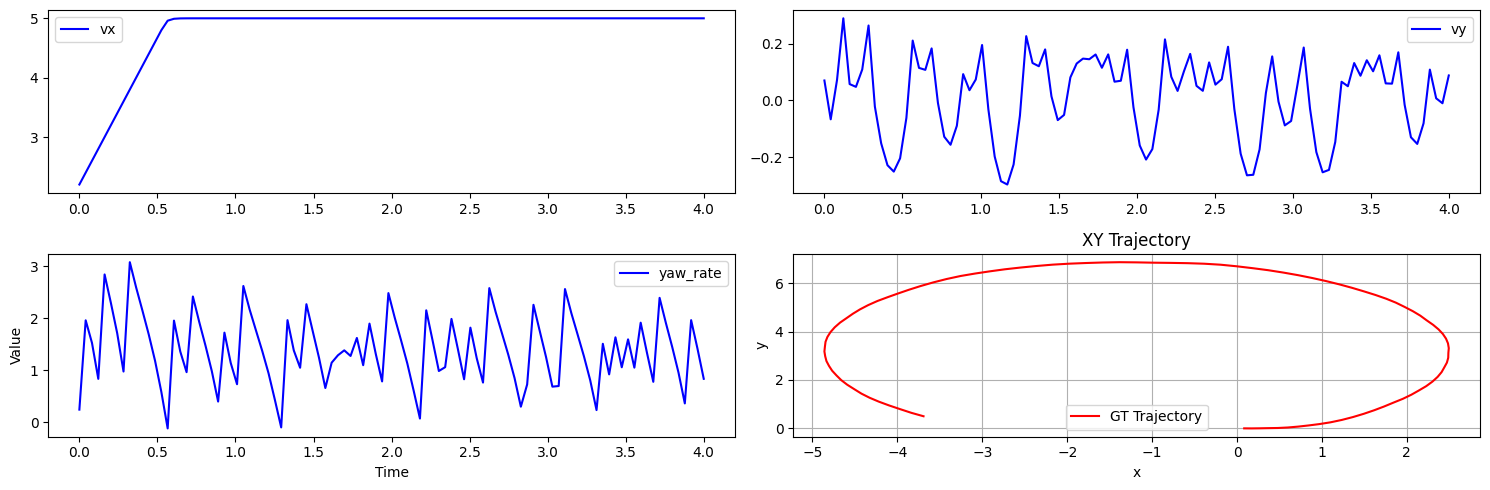

In [6]:
dummy_traj_length = 100
initial_state = torch.tensor([0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0]).to(DEVICE)
control_inputs = torch.tensor([[0.35, 5.0]]*dummy_traj_length).to(DEVICE)
pred_states = rk4_integrator(initial_state, control_inputs)
ti = torch.linspace(0.0, sample_interval*dummy_traj_length, steps=dummy_traj_length)
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0][0].plot(ti, pred_states[:, 4].cpu().detach().numpy(), label='vx', color='blue')
ax[0][0].legend()
ax[0][1].plot(ti, pred_states[:, 5].cpu().detach().numpy(), label='vy', color='blue')
ax[0][1].legend()
ax[1][0].plot(ti, pred_states[:, 6].cpu().detach().numpy(), label='yaw_rate', color='blue')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Value')
ax[1][0].legend()

# Plot for XY trajectory
ax[1][1].plot(pred_states[:, 0].cpu().detach().numpy(), pred_states[:, 1].cpu().detach().numpy(), label='GT Trajectory', color='red')
ax[1][1].set_xlabel('x')
ax[1][1].set_ylabel('y')
ax[1][1].set_title('XY Trajectory')
ax[1][1].legend()
ax[1][1].grid(True)

plt.tight_layout()
plt.show()

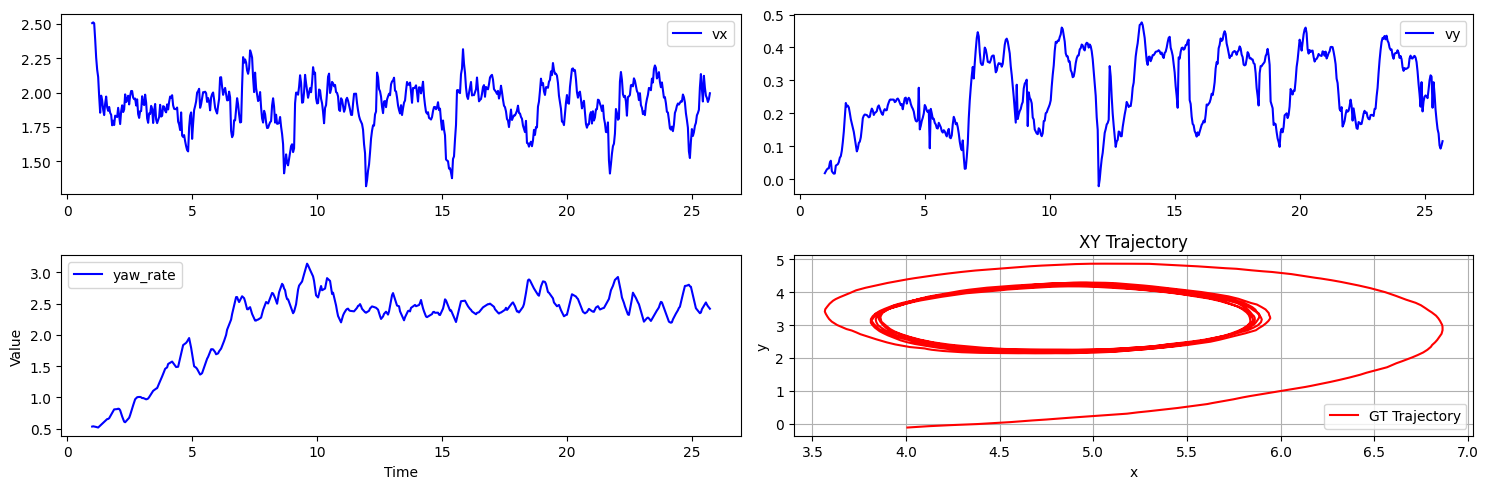

read batch data from../datasets/skir_2.csv, batch size113


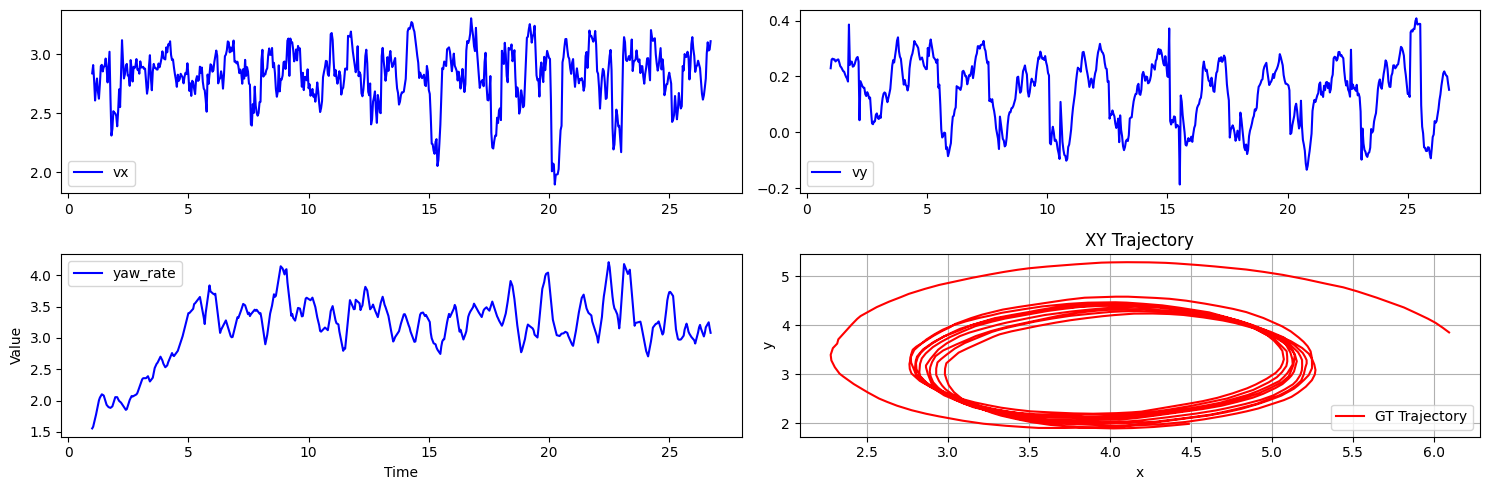

read batch data from../datasets/skir_4_3.csv, batch size118


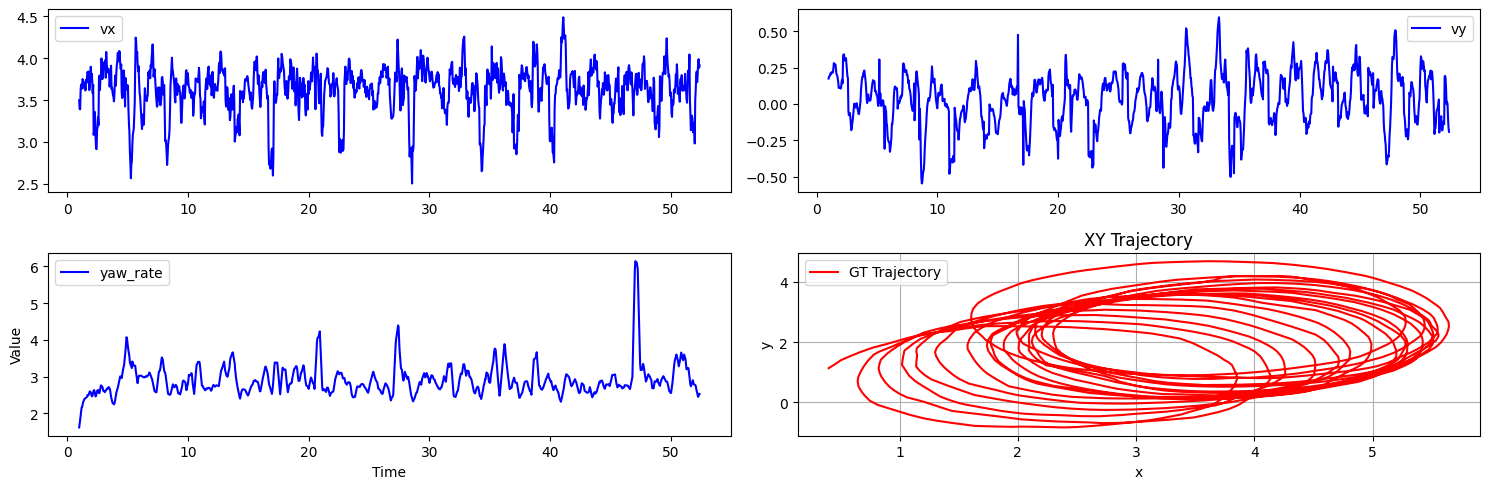

read batch data from../datasets/skir_5.csv, batch size246


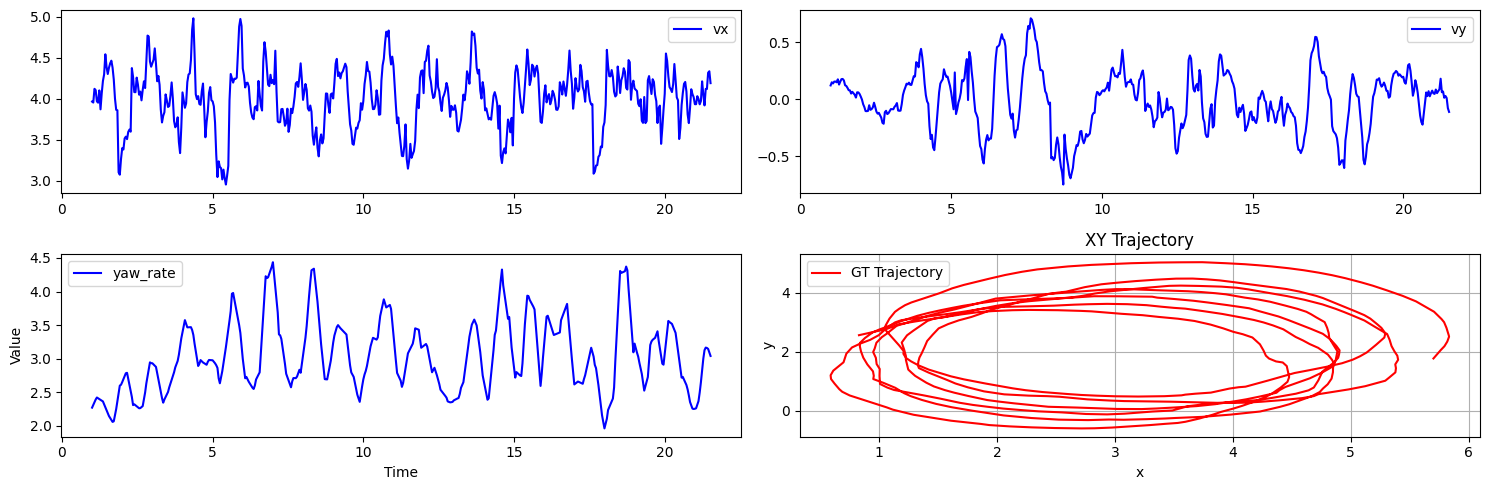

read batch data from../datasets/skir_6.csv, batch size92


In [106]:
# Initialize lists for concatenated data
all_initial_states = []
all_timestamps = []
all_control_inputs = []
all_target_states = []
for file_path in file_paths:
    traj_data = fetch_aligned_trajectory_data(file_path, sample_interval=sample_interval)
    batched_initial_states, batched_timestamps, batched_control_inputs, batched_target_states = \
           dynamic_batch_from_csv(traj_data, cut_off, DEVICE, step_gap=step_gap, horizon=horizon)
    plot_gt_traj(traj_data, cut_off=cut_off)
    print(f"read batch data from{file_path}, batch size{batched_initial_states.shape[0]}")
    # Append each batched tensor to its corresponding list
    all_initial_states.append(batched_initial_states)
    all_timestamps.append(batched_timestamps)
    all_control_inputs.append(batched_control_inputs)
    all_target_states.append(batched_target_states)
    cut_off = 25

# Concatenate all tensors in each list along the batch dimension
concatenated_initial_states = torch.cat(all_initial_states, dim=0)
concatenated_timestamps = torch.cat(all_timestamps, dim=0)
concatenated_control_inputs = torch.cat(all_control_inputs, dim=0)
concatenated_target_states = torch.cat(all_target_states, dim=0)

In [85]:
print(concatenated_initial_states.shape)

torch.Size([575, 7])


## Train

In [86]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(concatenated_initial_states, concatenated_control_inputs, concatenated_target_states,
                        concatenated_timestamps)

total_size = len(dataset)
test_size = int(total_size * 0.2)
train_size = total_size - test_size
print(f"training dataset size:{train_size}, testing dataset size:{test_size}")
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

training dataset size:460, testing dataset size:115


In [97]:
params_index = {
    "X": 0,
    "Y": 1,
    "DELTA": 2,
    "YAW": 3,
    "VX": 4,
    "VY": 5,
    "V": 4, # From the collected data
    "YAWRATE":6,
    "STEER": 0,
    "VEL": 1,
    "FFY": 0,
    "FRY": 1,
}
initial_value = {
    "Iz": 0.09, "a_max": 5.0, "a_min": -3.0, 's_min': -0.4189, 's_max': 0.4189, 'sv_min': -3.2, 'sv_max': 3.2, 'v_switch': 7.319,
    "h": 0.02, "lf": 0.162, "lr": 0.145, "lwb": 0.307, "mass": 3.31,
    "mu": 1.0, "tau_steer": 0.15, "Bf": 3.12, "Cf": 2.23, "Df": 0.72, "Ef": 0.23, "Br": 29.91, "Cr": 2.23, "Dr": 1.21, "Er": 0.92,
    'steer_delay_time': 0.05, "accel_delay_time": 0.05, "tire_model": "pacejka"
}
vel_pid = VelocityPID(max_accel=initial_value["a_max"], min_accel=initial_value["a_min"], switch_v=6.0, dt=initial_value["accel_delay_time"])
dynamic_f110 = DynamicBicycle_Steer(initial_value=initial_value, params_index=params_index, tire_model="pacejka", vel_pid=vel_pid).to(DEVICE)
dynamic_f110.steer_k.requires_grad = False
dynamic_f110.tire_model.mu.requires_grad = True

euler_integrator = Euler(dynamic_f110, timestep=sample_interval)
rk4_integrator = RK4(dynamic_f110, timestep=sample_interval)


def kinematic_steer_loss(pred, target, params_index):
    X, Y, YAW, V = params_index["X"], params_index["Y"], params_index["YAW"], params_index["V"]
    indices = [X, Y, V]
    pred_selected = pred[..., indices]
    target_selected = target[..., indices]
    loss = torch.abs(pred_selected - target_selected).mean()
    # NOTE: can not modify the varibale inplace, so yaw is regularized separately
    # regularize_yaw =  (pred[..., YAW] + math.pi) % (2 * math.pi) - math.pi

    # Compute the L1 loss
    # return torch.abs(pred_selected - target_selected).mean() + torch.abs(regularize_yaw - target[..., YAW]).mean()
    return loss

tensor(0.3593)


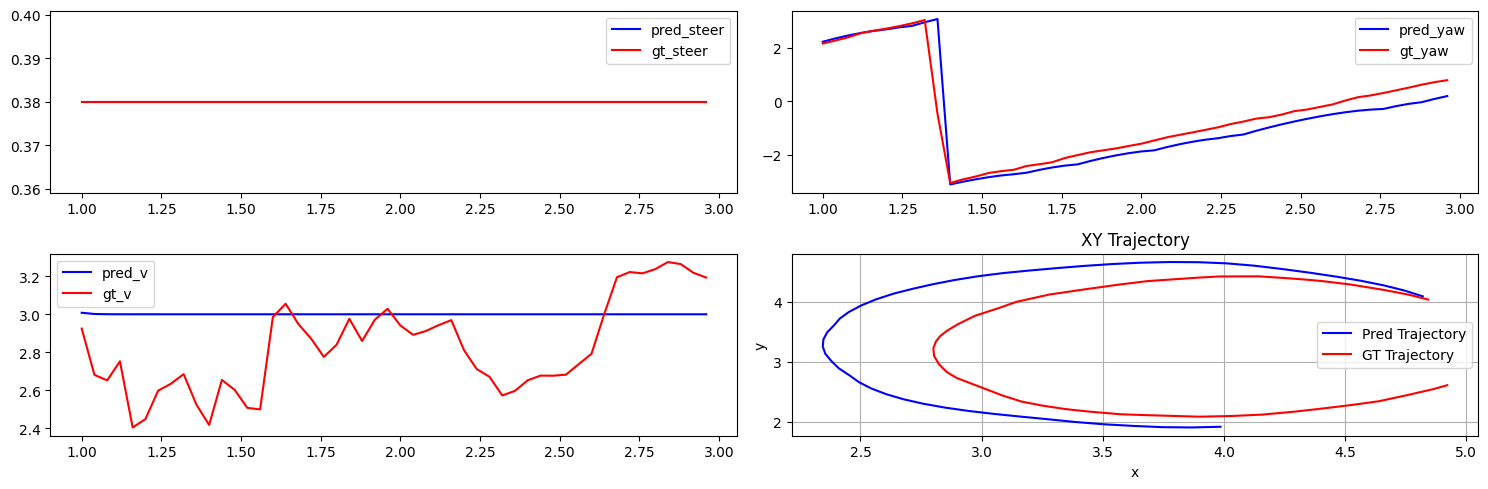

tensor(0.8070)


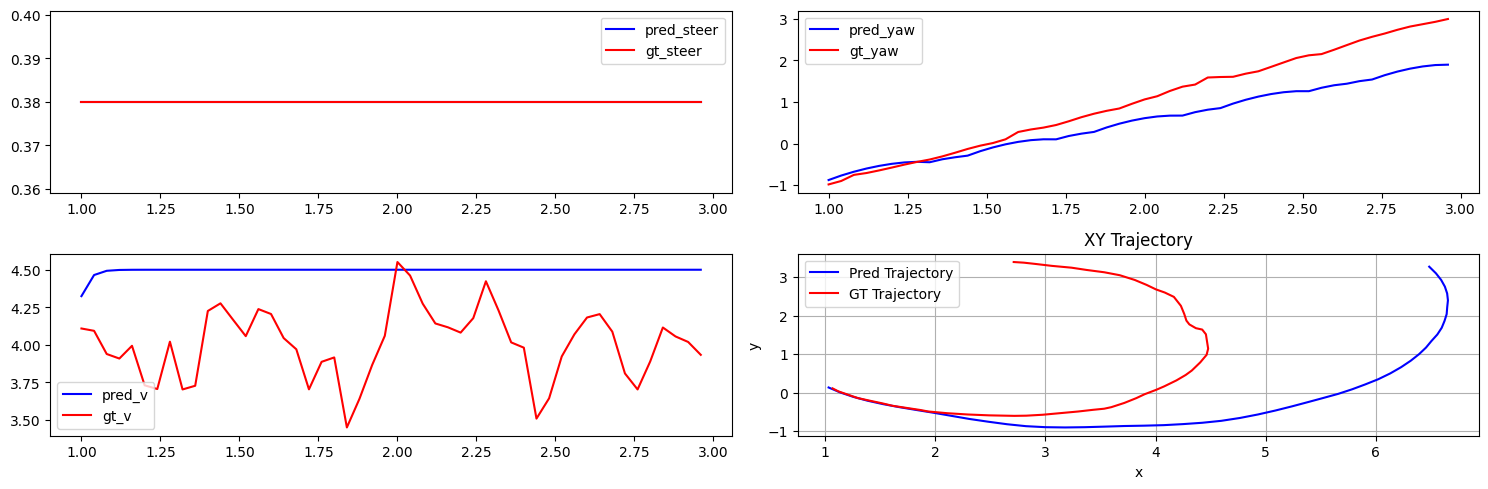

tensor(0.6725)


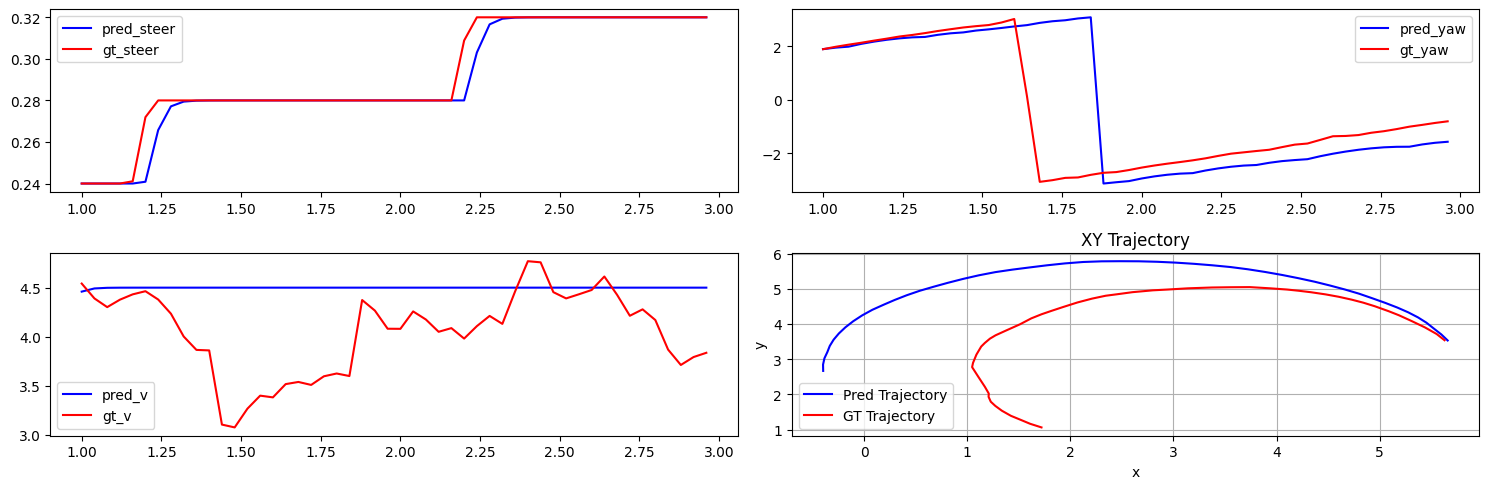

tensor(0.5700)


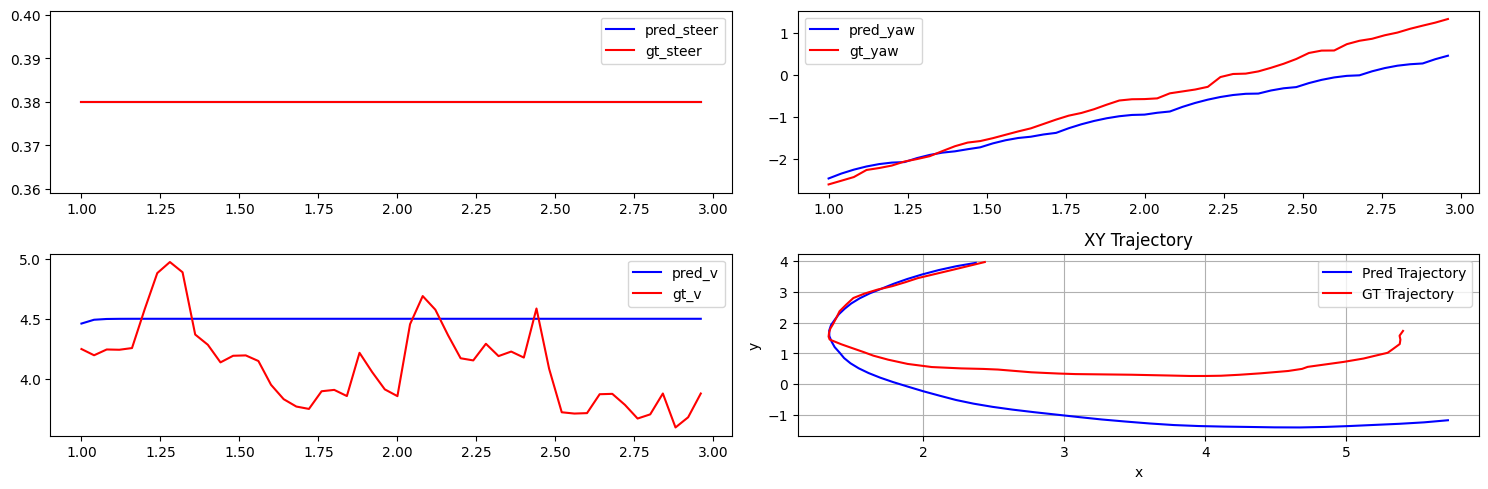

tensor(0.9659)


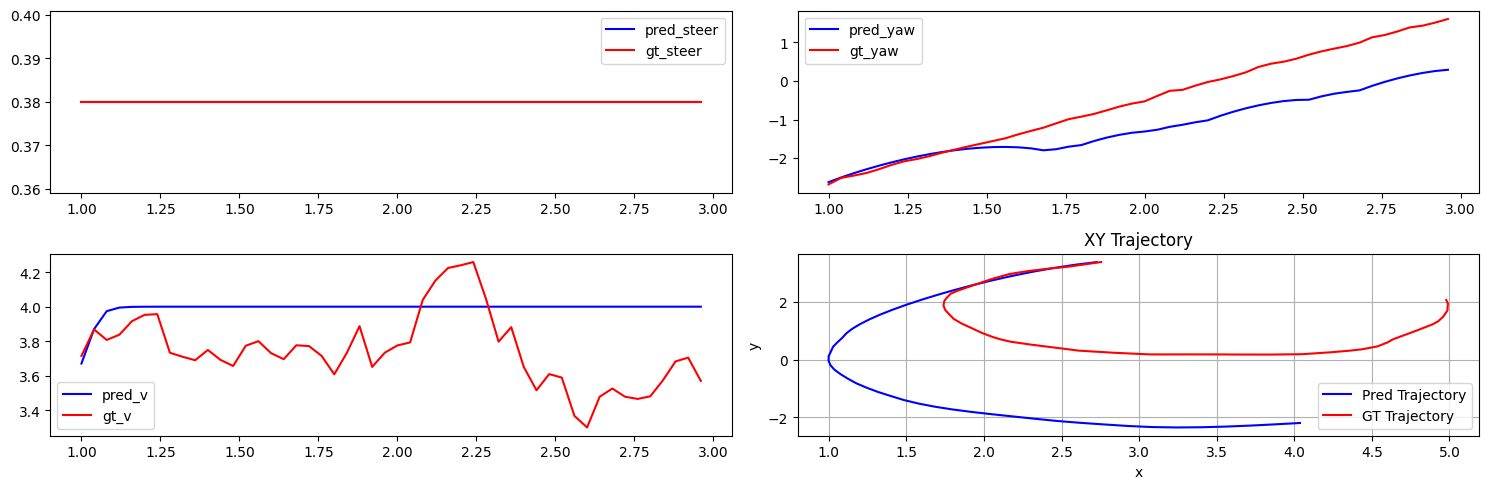

tensor(0.6706)


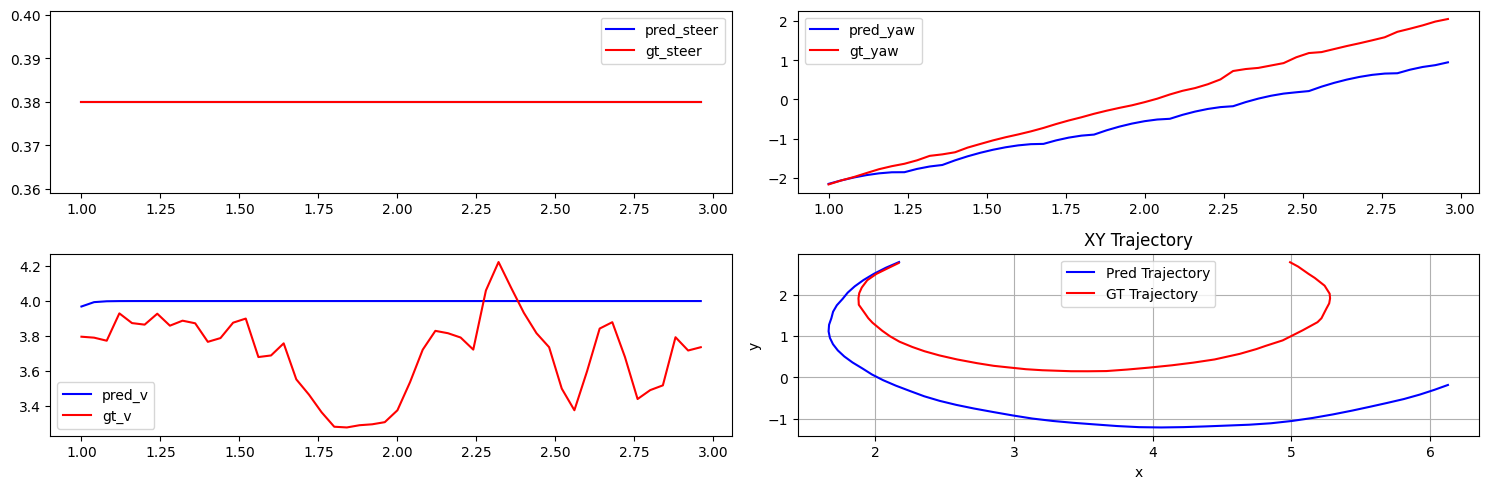

tensor(0.8821)


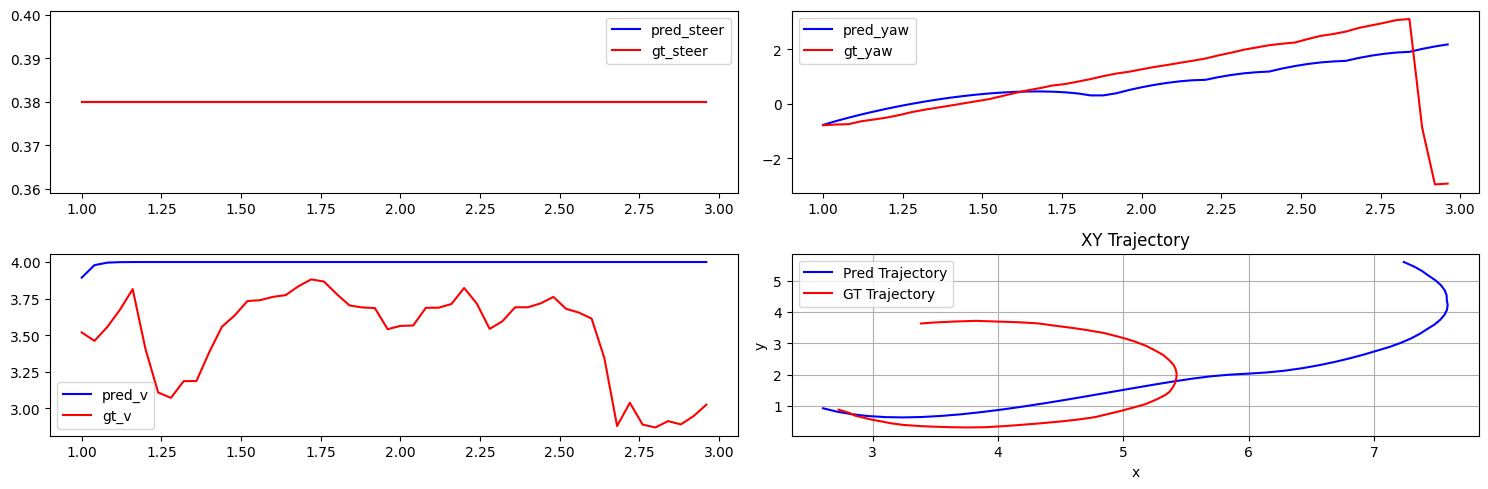

tensor(0.6732)


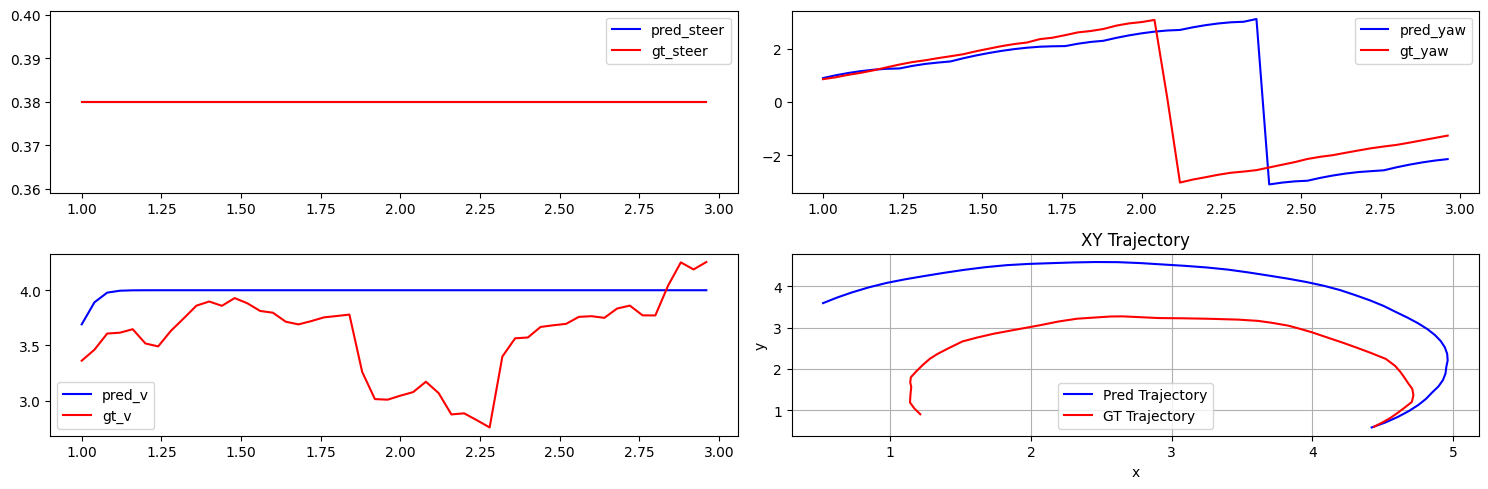

tensor(0.3538)


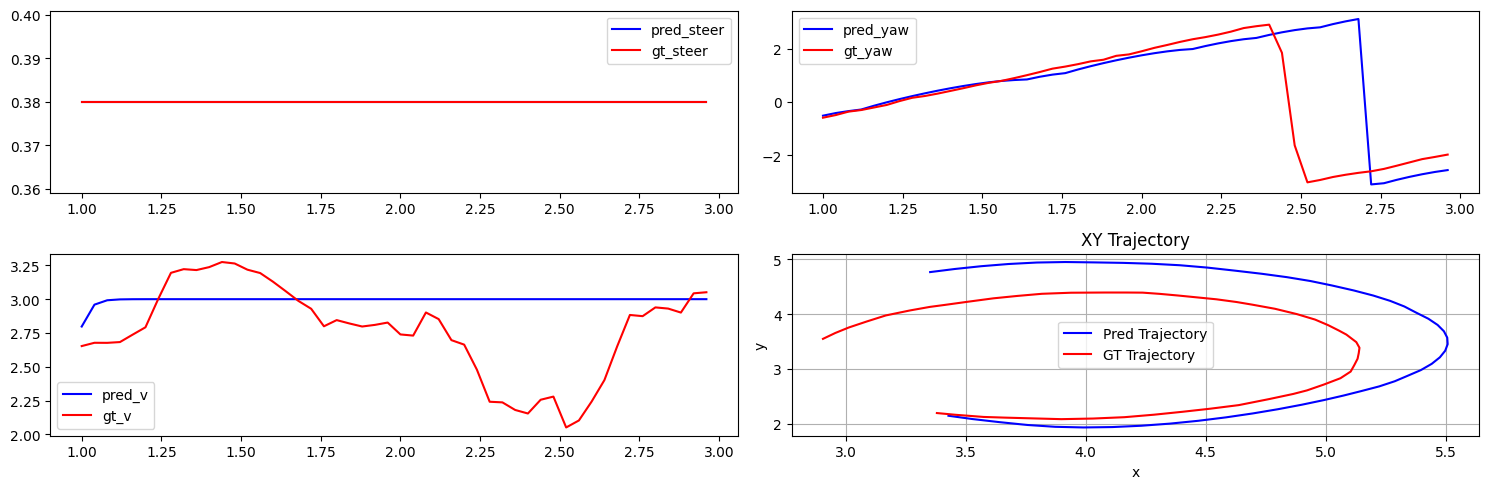

tensor(0.6330)


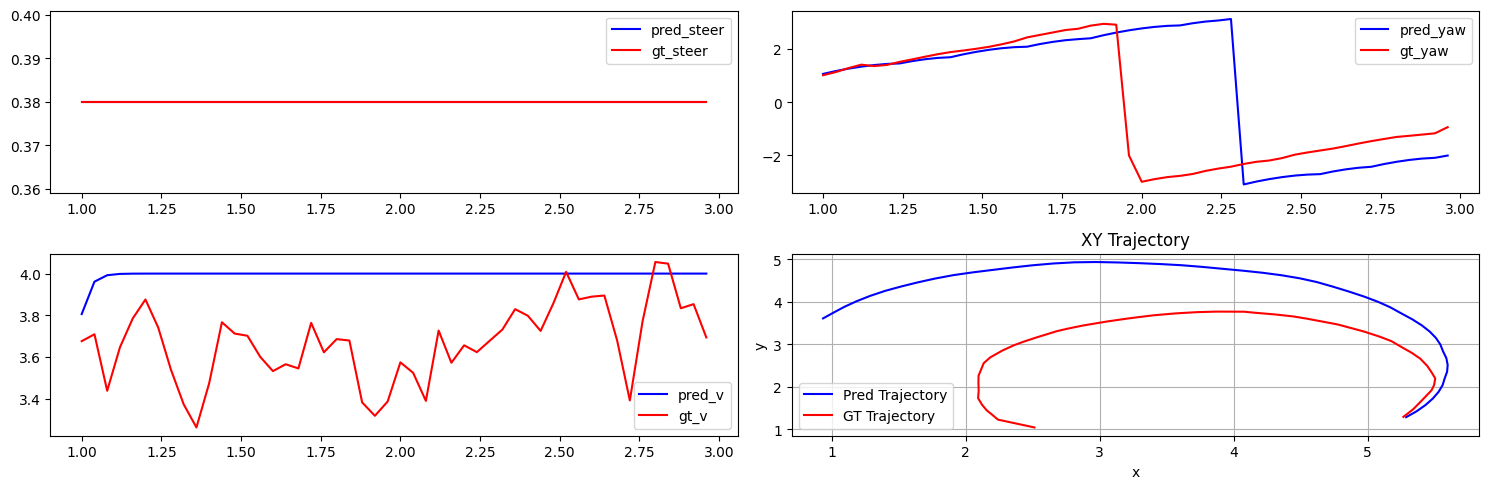

tensor(0.7680)


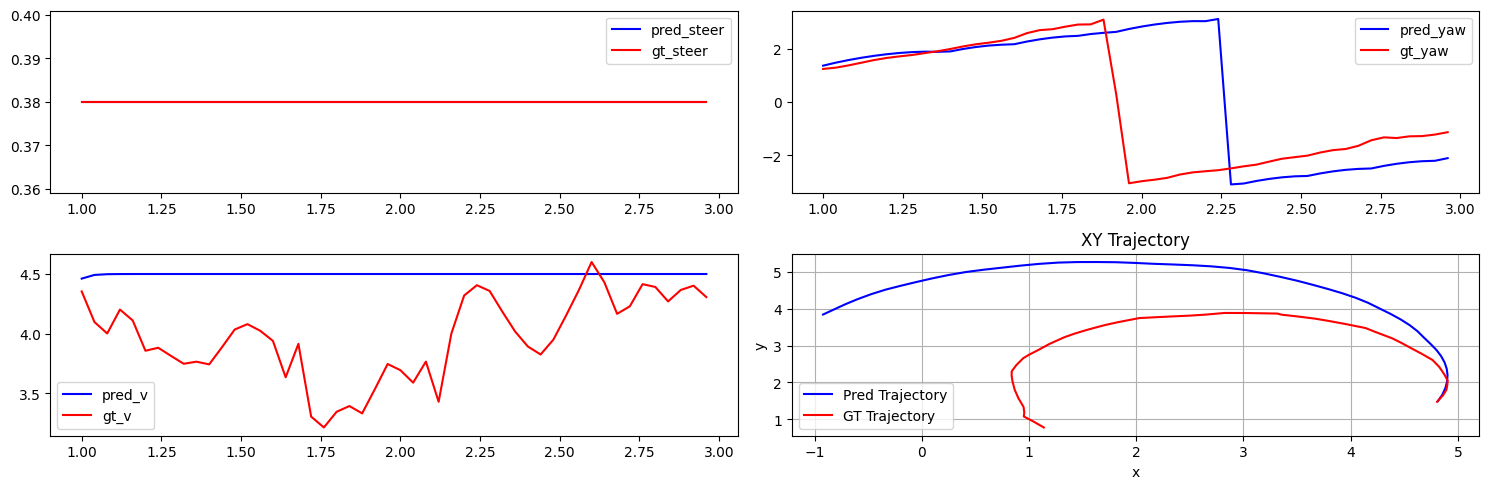

tensor(0.6482)


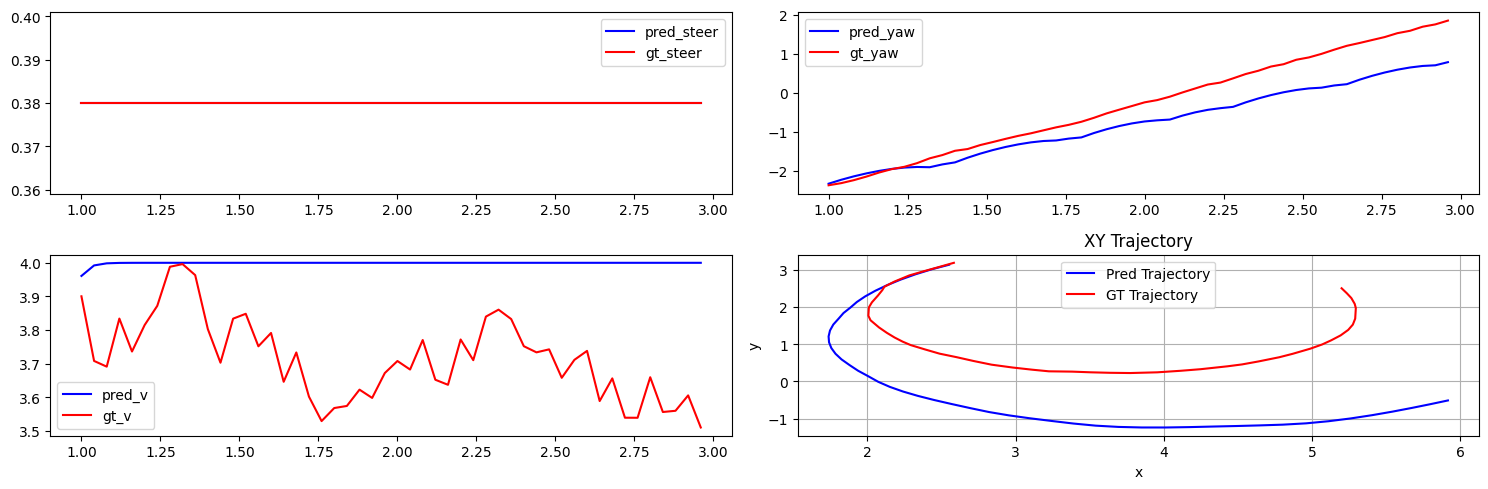

tensor(0.3704)


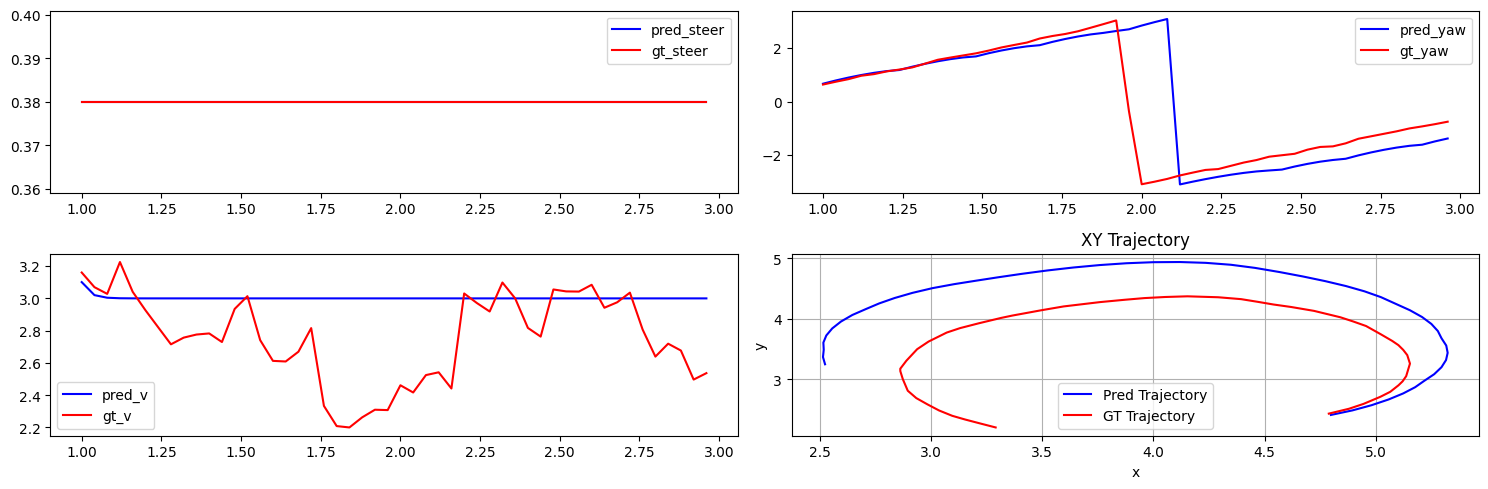

tensor(0.7249)


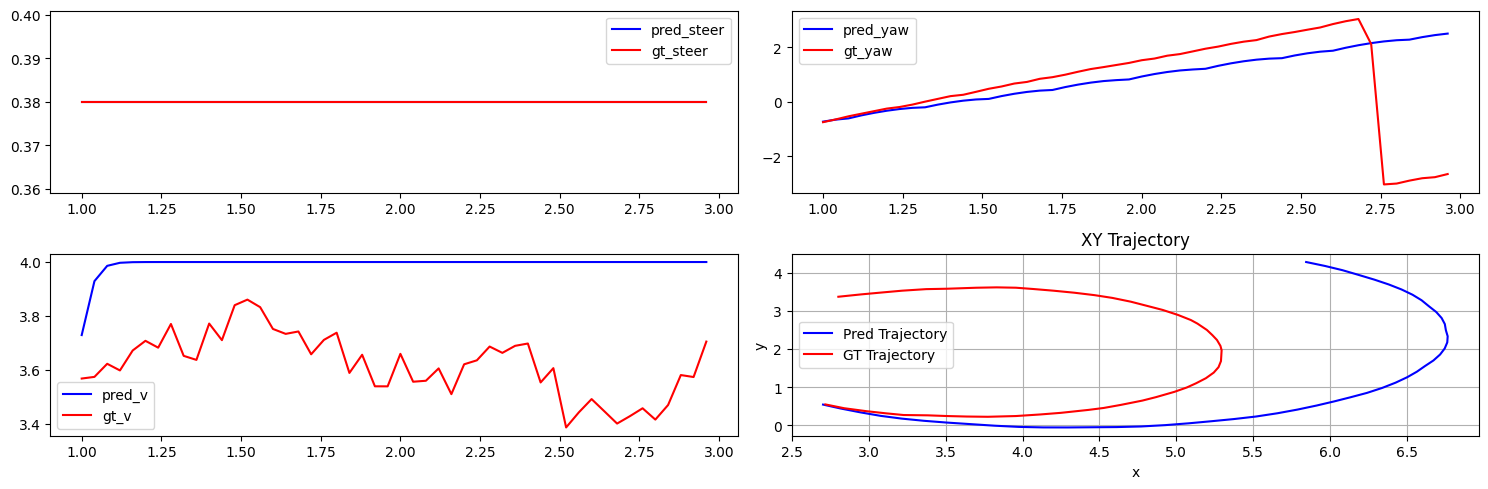

tensor(0.2821)


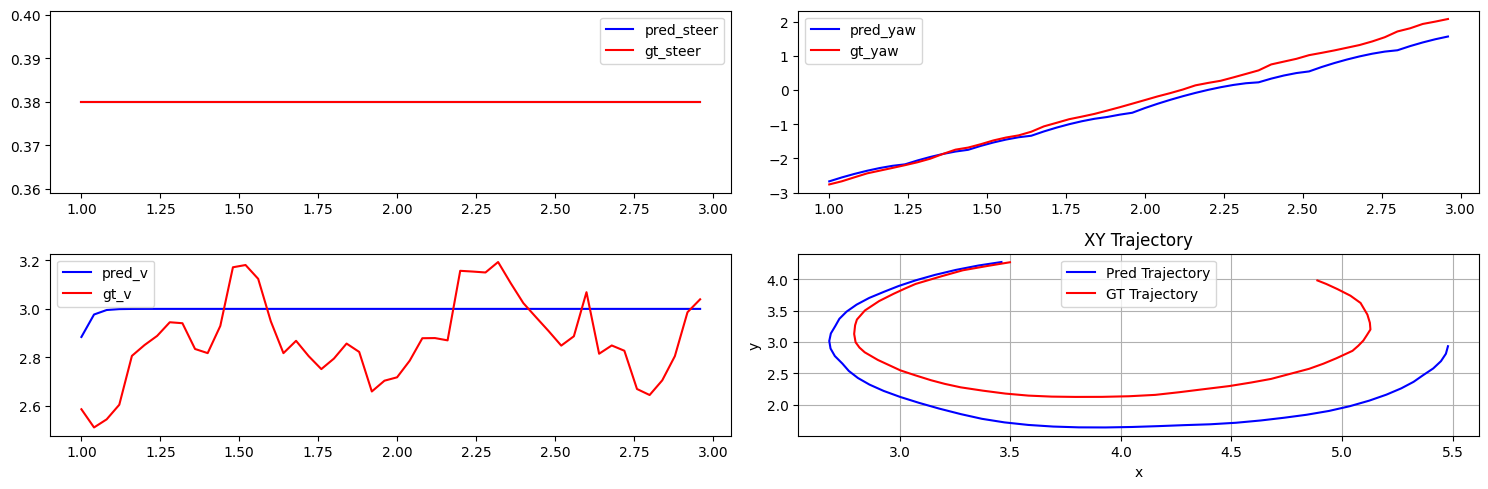

tensor(0.7056)


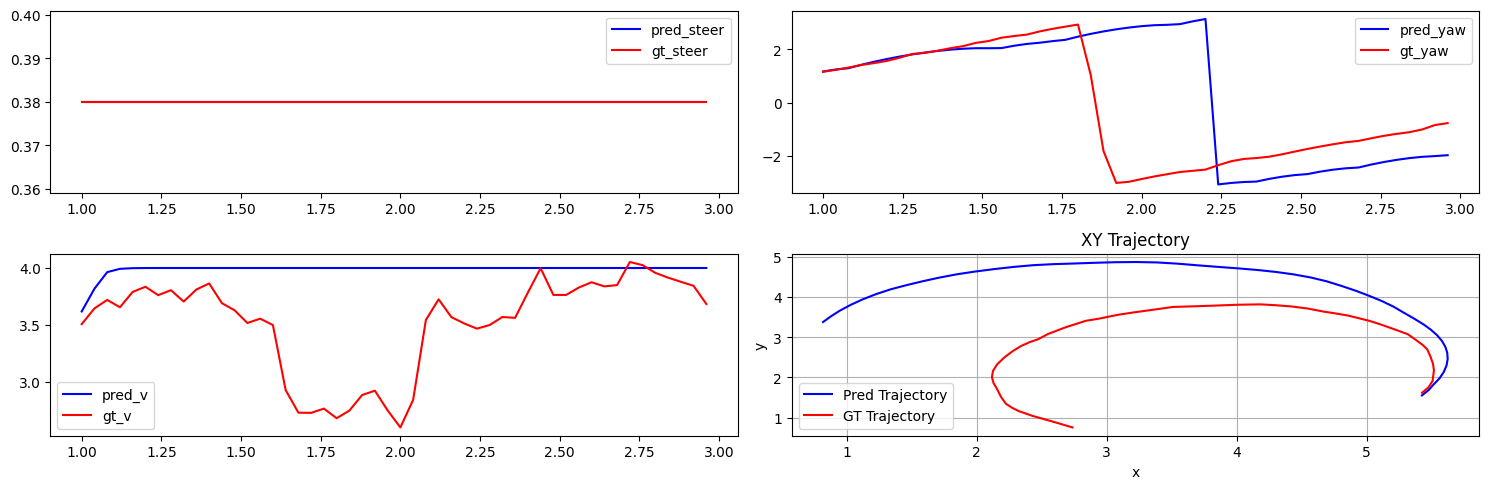

tensor(0.5974)


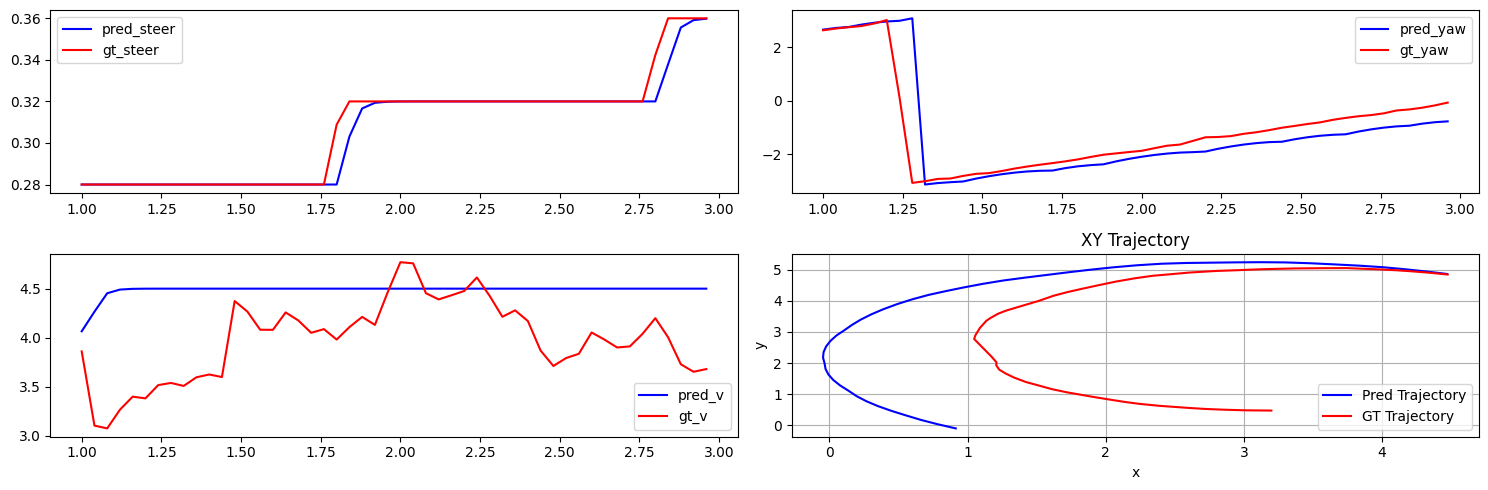

tensor(0.5505)


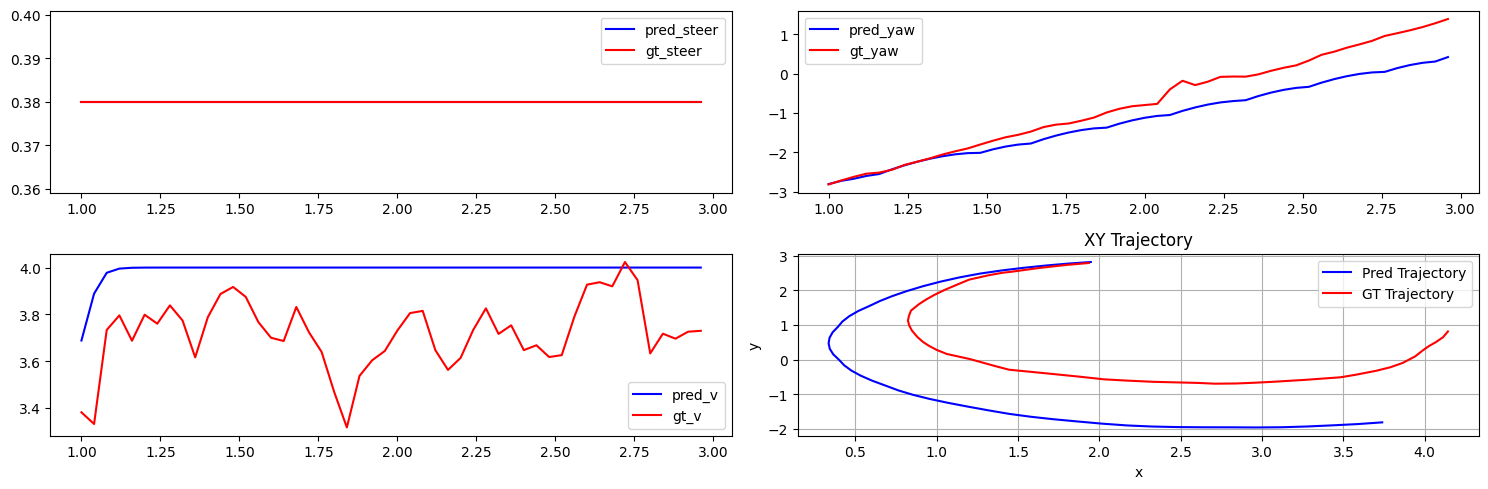

tensor(0.6341)


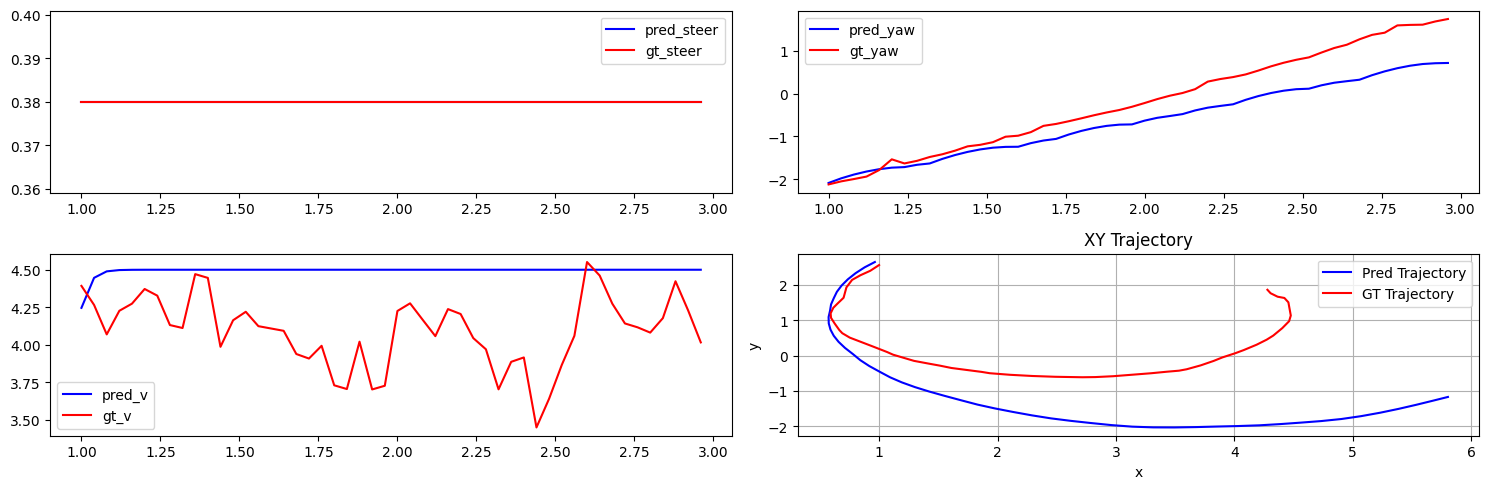

tensor(0.3257)


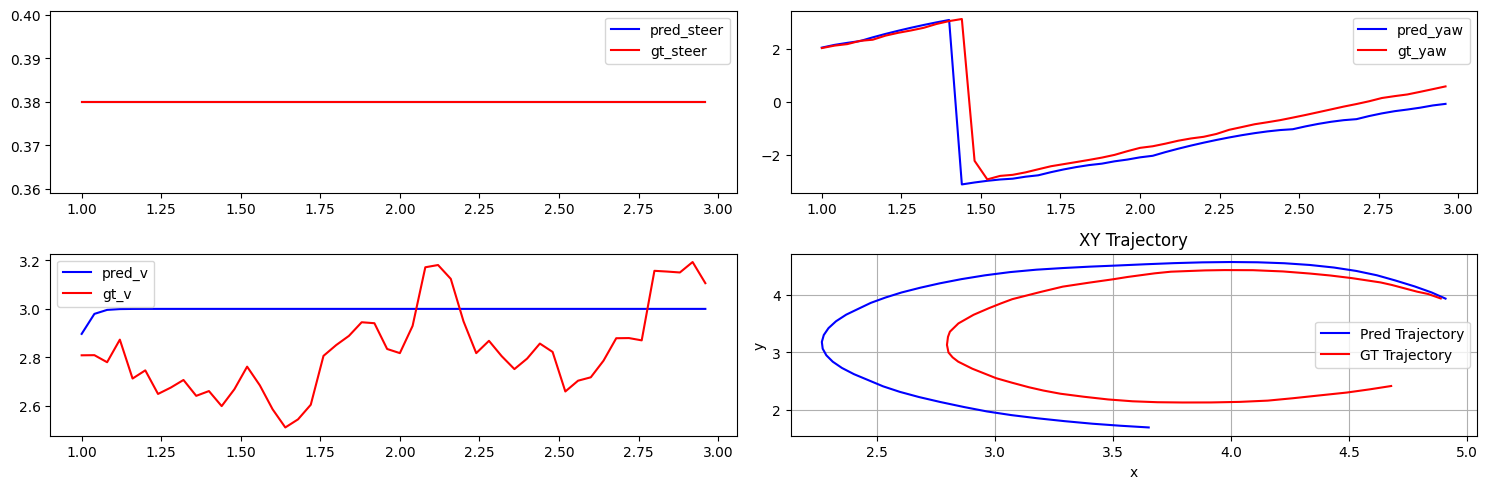

tensor(0.6402)


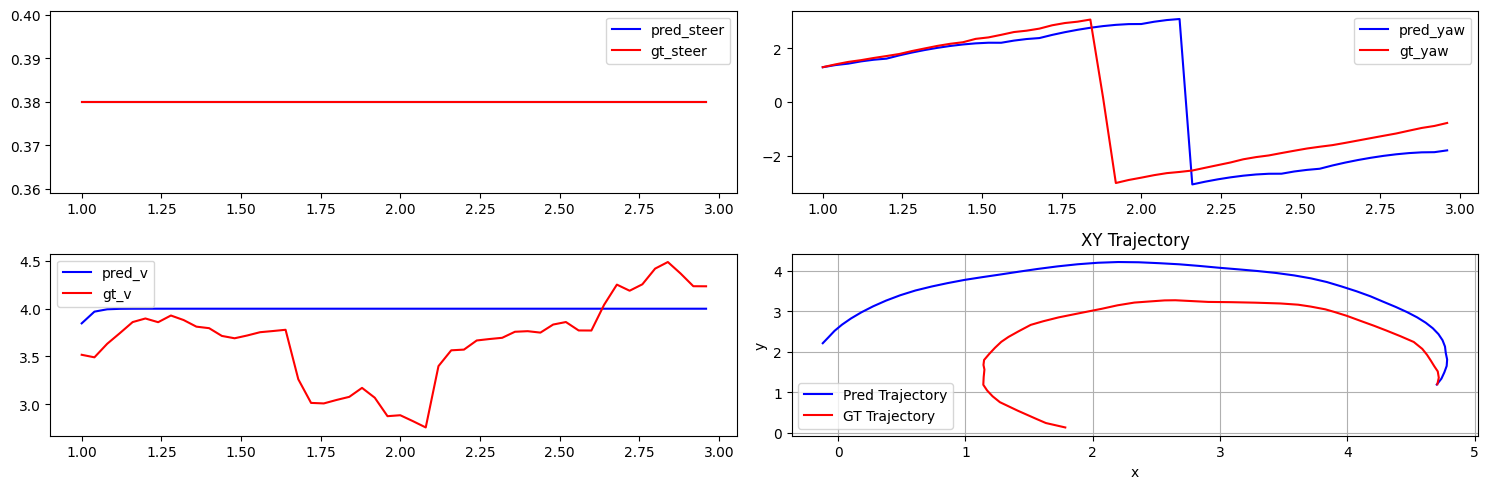

tensor(0.6923)


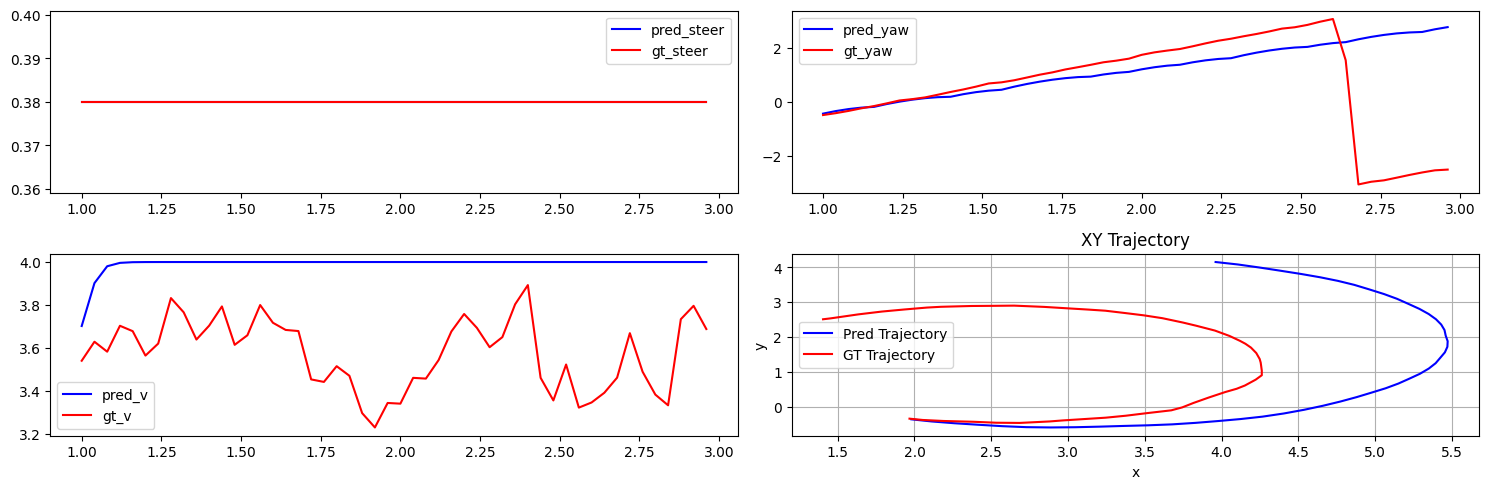

tensor(0.1913)


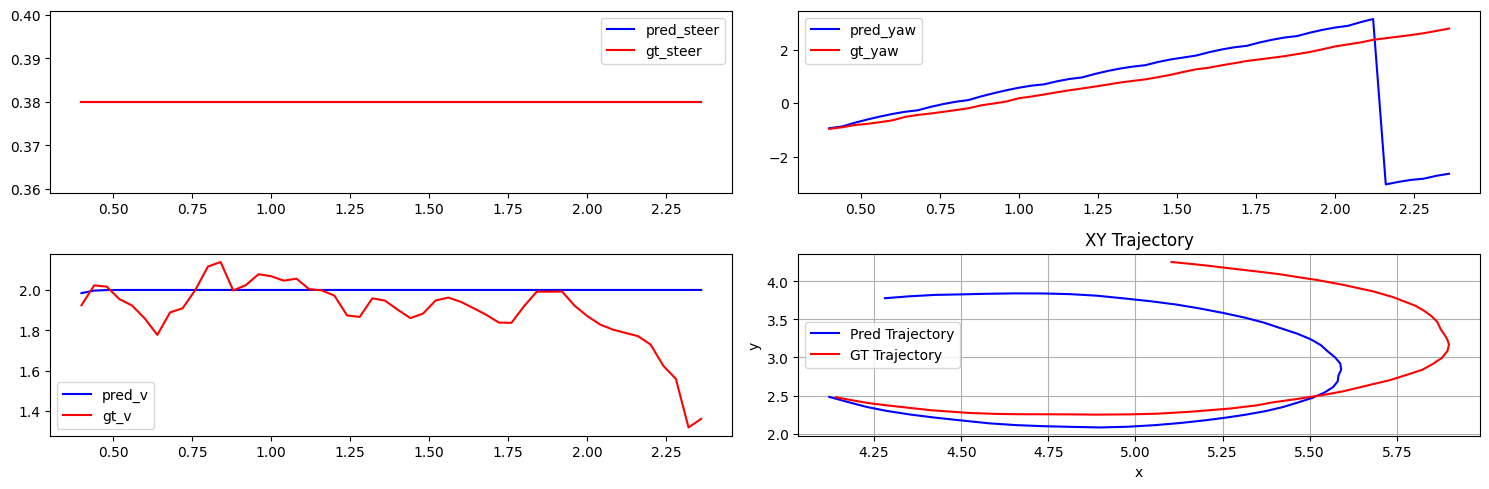

tensor(0.6736)


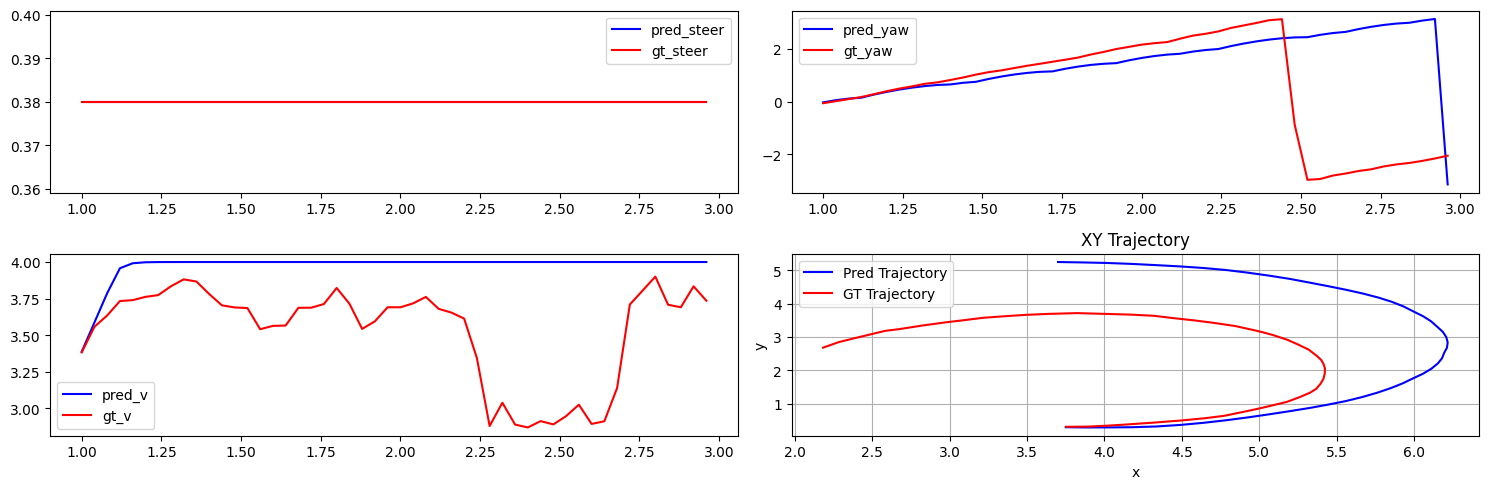

tensor(0.4521)


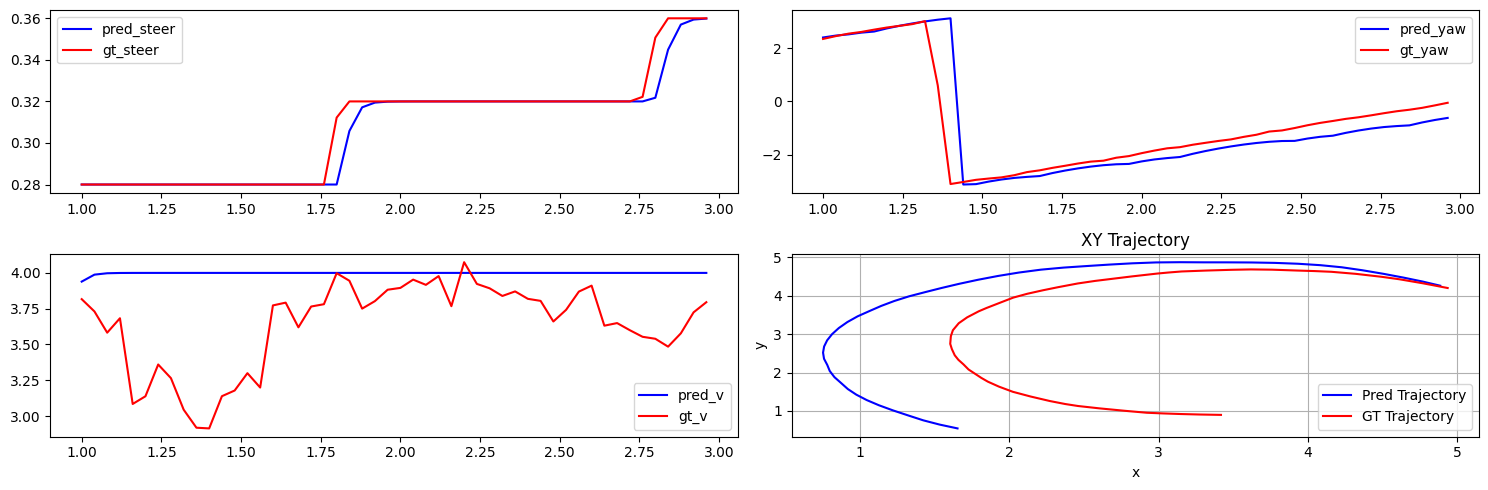

tensor(0.1208)


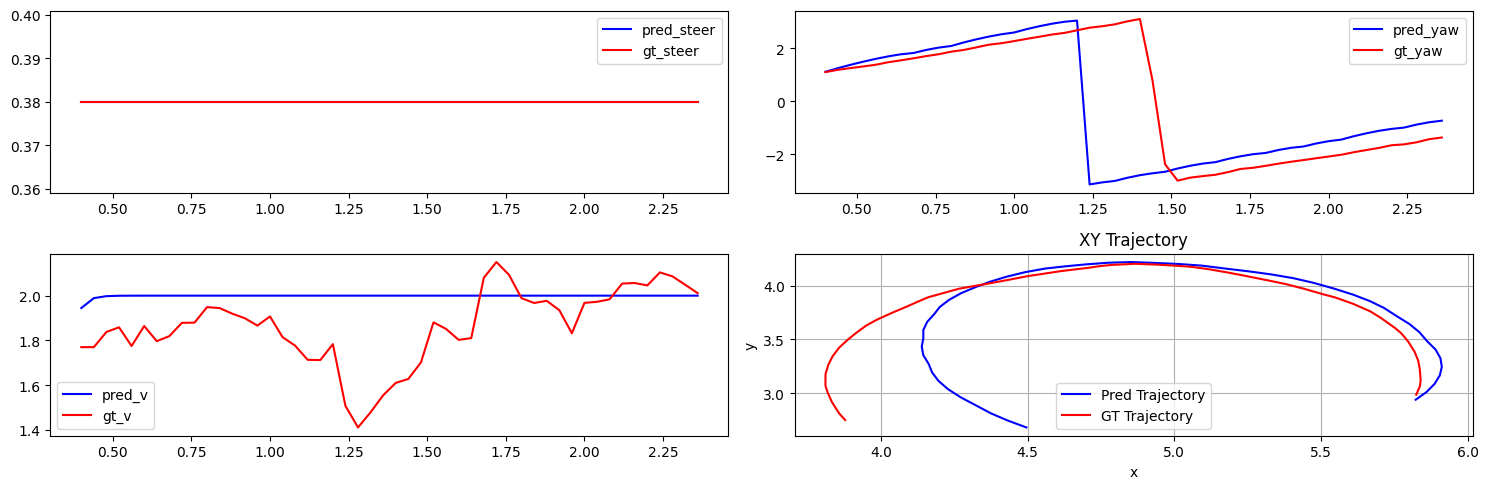

tensor(0.1401)


KeyboardInterrupt: 

In [90]:
with torch.no_grad():
    val_loss = 0.0
    for initial, inputs, targets, timestamps in test_dataloader:
        pred_states = euler_integrator(initial, inputs)
        batch_val_loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        print(batch_val_loss)
        for i in range(len(pred_states)):
            if i==0:
                plot_states(pred_states[i].cpu().detach().numpy(), targets[i].cpu().detach().numpy(), timestamps[i].cpu().detach().numpy())

In [99]:
from tqdm.auto import tqdm
EPOCHS = 30
optimizer = torch.optim.SGD(dynamic_f110.parameters(), lr=0.001, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

train_losses = []
val_losses = []
lrs = []
# torch.autograd.set_detect_anomaly(False)


for i in tqdm(range(EPOCHS)):
    # Evaluation on test dataset
    for name, param in dynamic_f110.named_parameters():
       if param.requires_grad:
           print(name, param.data, param.grad)
        # plot_states(pred_states[0].cpu().detach().numpy(), targets[0].cpu().detach().numpy(), timestamps[0])
        # print(f"Epoch: {i} | Training Loss: {loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    for initial, inputs, targets, timestamps in train_dataloader:
        optimizer.zero_grad()
        # pred_states = rk4_integrator(initial, inputs)
        pred_states = euler_integrator(initial, inputs)
        loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        loss.backward()
        print(loss.grad())
        print(loss.item())
        for name, param in dynamic_f110.named_parameters():
           if param.requires_grad:
               print(name, param.data, param.grad)
        assert False
        # optimizer.step()
    with torch.no_grad():
        val_loss = 0.0
        for initial, inputs, targets, timestamps in test_dataloader:
            pred_states = rk4_integrator(initial, inputs)
            batch_val_loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
            val_loss += batch_val_loss.item()
    print(f"Epoch: {i} | Training Loss: {loss.item()} | LR: {optimizer.param_groups[0]['lr']} | Val loss: {val_loss:.4f}")
    lrs.append(optimizer.param_groups[0]['lr'])
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    scheduler.step(val_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

tire_model.mu tensor(1.) tensor(2.5062e+08)


/tmp/ipykernel_28889/2415793719.py:25: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(loss.grad())


TypeError: 'NoneType' object is not callable

In [ ]:
with torch.no_grad():
    val_loss = 0.0
    for initial, inputs, targets, timestamps in test_dataloader:
        pred_states = rk4_integrator(initial, inputs)
        batch_val_loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        for i in range(len(pred_states)):
            if i%20==0:
                plot_states(pred_states[i].cpu().detach().numpy(), targets[i].cpu().detach().numpy(), timestamps[i].cpu().detach().numpy())